## 项目名称 电商多店铺销售分析与可视化报告

## 1.项目简介
数据来源:模拟生成(2024-2025,三家店铺)
分析目标:
1.掌握基础统计与趋势
2.计算环比/同比。识别异常
3.可视化展示多维度数据
4.形成完整的业务分析闭环

## 2.数据准备
在这一部分，生成2024-2025年3家店铺(A,B,C)的模拟销售数据，包含销售额(sales)、订单数量(orders)、顾客数(customers)三个核心指标。
生成后，先做基本的结构检查，确保数据维度和类型正确，再进行初步统计分析

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

#生成随机日期以及数据
dates = pd.date_range('2024-01-01', periods=24, freq='ME')
stores = ['A', 'B', 'C']

np.random.seed(42)
data = []
for store in stores:
    base_sales = np.random.randint(80,150)
    base_orders = np.random.randint(40,90)
    base_customers = np.random.randint(30,70)
    for d in dates:
        sales = base_sales + np.random.randint(-20,20)
        orders = base_orders + np.random.randint(-10,10)
        customers = base_customers + np.random.randint(-5,5)
        data.append([d, store, sales, orders, customers])

df = pd.DataFrame(data, columns=['date', 'store', 'sales', 'orders', 'customers'])

In [4]:
#数据预览
print(df.head())
print(df.info())
print(df.describe())

        date store  sales  orders  customers
0 2024-01-31     A    118      64         48
1 2024-02-29     A    129      68         46
2 2024-03-31     A    146      65         46
3 2024-04-30     A    113      59         46
4 2024-05-31     A    140      63         40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       72 non-null     datetime64[ns]
 1   store      72 non-null     object        
 2   sales      72 non-null     int64         
 3   orders     72 non-null     int64         
 4   customers  72 non-null     int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 2.9+ KB
None
                      date       sales     orders  customers
count                   72   72.000000  72.000000  72.000000
mean   2025-01-14 09:00:00  112.680556  55.152778  46.236111
min    2024-01-31 00:00:00   86.000000  38

可以看到，数据集一共 72 行（24 个月 × 3 家店铺），字段类型正确：

date：datetime64 类型
store：类别型
sales / orders / customers：整数

初步统计显示：

销售额范围大致在 60 - 170 之间
订单数在 30 - 100 之间
顾客数在 20 - 70 之间

## 3.数据清洗
- 缺失值处理
- 异常值检测
- 数据类型转换

In [ ]:
#转换数据类型--date
df['date'] = df.to_datetime(df['date'])

#由于该项目使用模拟数据，但现实情况存在多种缺失和异常，所以照常进行清洗
df = df.fillna(0) #这里将NaN替换为0

#异常值处理--这里将异常值定为同比增长率<=-0.4
#标记异常值
df['is_outlier'] = df['sales-MoM'] <= -0.4
#提取异常值
outlier = df[df['is_outlier']]
print(outlier)

## 4.数据分析

### 4.1时间序列处理
- 按月汇总，累计值、增长率

In [3]:
#按月、按店铺汇总销售额 & 订单数

def get_group_sum(df, groupby, values):
    result = df.groupby(groupby)[values].sum()
    return result

#按店铺
store_sales_customers = get_group_sum(df, 'store', ['sales', 'orders'])

#按月份
date_sales_customers = get_group_sum(df, 'date', ['sales', 'orders'])


### 4.2移动计算与窗口函数
- 移动平均、滚动指标

In [5]:
#客单价
df['customer_price'] = df['sales'] / df['customers']

#分组计算累计销售额
df['cumsum_sales'] = df.groupby('store')['sales'].cumsum()

#3个月的销售移动平均
df['rolling_mean'] = df.groupby('store')['sales'].rolling(3).mean().reset_index(level=0, drop=True)


### 4.3同比/环比分析
- 同比/环比的计算

In [15]:
#环比/同比
def get_rate(df,values,kind='MoM'):
    if kind == 'MoM':
        df[f'{values}-MoM'] = df.groupby('store')[values].pct_change()
    elif kind == 'YoY':
        df[f'{values}-YoY'] = df.groupby('store')[values].pct_change(12)
    return df
    
get_rate(df,'sales',kind='MoM')
get_rate(df, 'sales', kind='YoY')

,date,store,sales,orders,customers,customer_price,cumsum_sales,rolling_mean,sales-MoM,sales-YoY
0,2024-01-31,A,118,64,48,2.458333,118,NaN,NaN,NaN
1,2024-02-29,A,129,68,46,2.804348,247,NaN,0.093220,NaN
2,2024-03-31,A,146,65,46,3.173913,393,131.000000,0.131783,NaN
3,2024-04-30,A,113,59,46,2.456522,506,129.333333,-0.226027,NaN
4,2024-05-31,A,140,63,40,3.500000,646,133.000000,0.238938,NaN
...,...,...,...,...,...,...,...,...,...,...
67,2025-08-31,C,96,55,67,1.432836,2019,105.666667,-0.067961,0.116279
68,2025-09-30,C,116,47,63,1.841270,2135,105.000000,0.208333,0.045045
69,2025-10-31,C,92,53,70,1.314286,2227,101.333333,-0.206897,0.033708
70,2025-11-30,C,87,38,65,1.338462,2314,98.333333,-0.054348,-0.147059


### 4.5处理后的数据

In [7]:
#1.按店铺月份分组的销售额和订单数
print(store_sales_customers)
print(date_sales_customers)

       sales  orders
store               
A       3084    1602
B       2593    1229
C       2436    1140
            sales  orders
date                     
2024-01-31    348     170
2024-02-29    349     164
2024-03-31    374     165
2024-04-30    314     154
2024-05-31    350     161
2024-06-30    359     164
2024-07-31    315     162
2024-08-31    343     182
2024-09-30    334     153
2024-10-31    333     160
2024-11-30    352     152
2024-12-31    302     180
2025-01-31    311     157
2025-02-28    334     173
2025-03-31    323     175
2025-04-30    354     161
2025-05-31    365     155
2025-06-30    334     162
2025-07-31    351     165
2025-08-31    333     177
2025-09-30    357     174
2025-10-31    331     168
2025-11-30    301     171
2025-12-31    346     166


In [8]:
#2.新数据
df_new = df
print(df)

         date store  sales  orders  customers  customer_price  cumsum_sales  \
0  2024-01-31     A    118      64         48        2.458333           118   
1  2024-02-29     A    129      68         46        2.804348           247   
2  2024-03-31     A    146      65         46        3.173913           393   
3  2024-04-30     A    113      59         46        2.456522           506   
4  2024-05-31     A    140      63         40        3.500000           646   
..        ...   ...    ...     ...        ...             ...           ...   
67 2025-08-31     C     96      55         67        1.432836          2019   
68 2025-09-30     C    116      47         63        1.841270          2135   
69 2025-10-31     C     92      53         70        1.314286          2227   
70 2025-11-30     C     87      38         65        1.338462          2314   
71 2025-12-31     C    122      46         69        1.768116          2436   

    rolling_mean  
0            NaN  
1            

### 4.4综合可视化
- 叠加图标、双坐标、趋势图

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15956\171514933.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(dates)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15956\171514933.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(pd.to_datetime(dates).strftime('%Y-%m'), rotation=45)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15956\171514933.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(dates)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15956\171514933.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(pd.to_datetime(dates).strftime('%Y-%m'), rotation=45

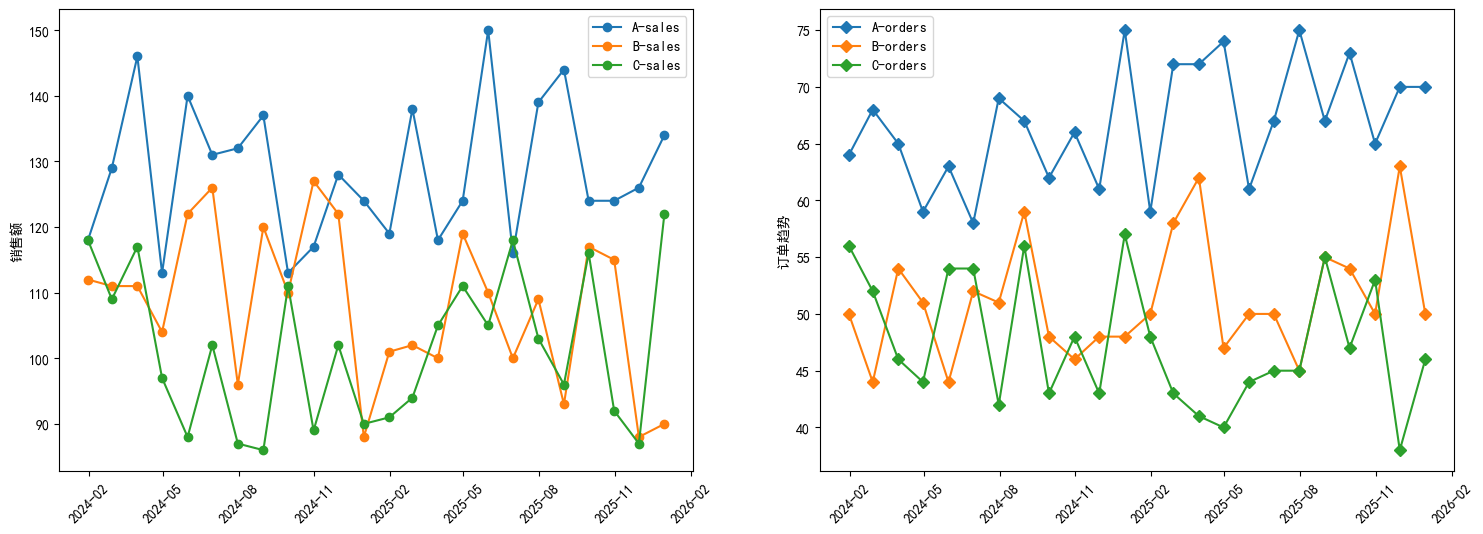

In [13]:
#获取所有日期(整个df的日期，不分店铺)
dates = df['date'].sort_values().unique()

#画布1
fig1, axes = plt.subplots(1,2, figsize=(18,6))

#销售额趋势折线图
for store in df['store'].unique():
    subset = df[df['store']==store]
    axes[0].plot(subset['date'], subset['sales'], marker='o', label=f'{store}-sales')

axes[0].legend()
axes[0].set_ylabel('销售额')
axes[0].set_xticklabels(dates)
axes[0].set_xticklabels(pd.to_datetime(dates).strftime('%Y-%m'), rotation=45)

#订单趋势折线图
for store in df['store'].unique():
    subset = df[df['store']==store]
    axes[1].plot(subset['date'], subset['orders'], marker='D',label=f'{store}-orders')

axes[1].legend()
axes[1].set_ylabel('订单趋势')
axes[1].set_xticklabels(dates)
axes[1].set_xticklabels(pd.to_datetime(dates).strftime('%Y-%m'), rotation=45)


import matplotlib.dates as mdates

# 设定主刻度为每3个月（季度）
for ax in axes:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', rotation=45)


## 5.进阶
- 两个深入展示(pivot_table/高级可视化)

store         A    B    C
date                     
2024-01-31  118  112  118
2024-02-29  129  111  109
2024-03-31  146  111  117
2024-04-30  113  104   97
2024-05-31  140  122   88
2024-06-30  131  126  102
2024-07-31  132   96   87
2024-08-31  137  120   86
2024-09-30  113  110  111
2024-10-31  117  127   89
2024-11-30  128  122  102
2024-12-31  124   88   90
2025-01-31  119  101   91
2025-02-28  138  102   94
2025-03-31  118  100  105
2025-04-30  124  119  111
2025-05-31  150  110  105
2025-06-30  116  100  118
2025-07-31  139  109  103
2025-08-31  144   93   96
2025-09-30  124  117  116
2025-10-31  124  115   92
2025-11-30  126   88   87
2025-12-31  134   90  122


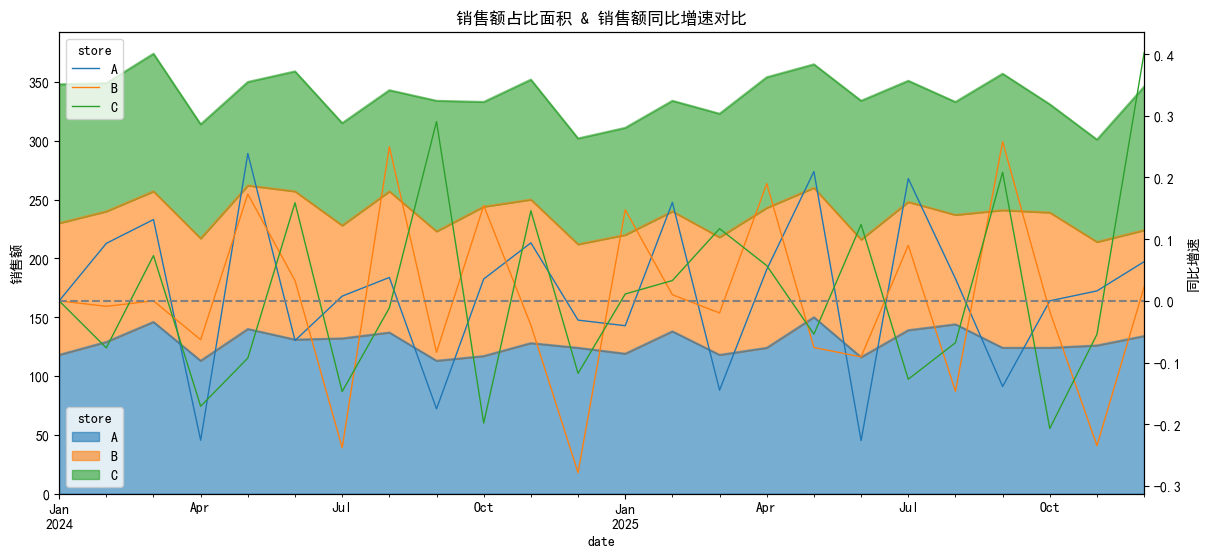

In [17]:
#前景图 + 背景图
pivot_df = df.pivot_table(index='date',
                         columns='store',
                         values=['sales','sales-MoM'],
                         aggfunc='sum')


pivot_df_sales = pivot_df['sales']
pivot_df_rate = pivot_df['sales-MoM']

print(pivot_df_sales)

fig, ax1 = plt.subplots(figsize=(14,6))

#销售额堆叠占比面积图
pivot_df_sales.plot(kind='area', stacked=True, ax=ax1, alpha=0.6)
ax1.set_ylabel('销售额')
ax1.set_title('销售额占比面积 & 销售额同比增速对比')

#同比增速对比(双轴线，带0%基准线)
ax2 = ax1.twinx()
pivot_df_rate.plot(ax=ax2, linewidth=1)
ax2.set_ylabel('同比增速')
ax2.axhline(0, color='gray',linestyle='--')

## 6.结果与业务结论


- **整体趋势**  
  - 店铺 A 销售额整体最高，增长相对稳定；店铺 C 波动较大。
  - 订单量与销售额大致同步，但在部分月份存在差异，说明客单价有波动。

- **同比/环比分析**  
  - 2024 Q3 出现明显的环比下滑，尤其是店铺 B（销售额环比下降超过 40%），属于异常波动。
  - 可能原因：促销活动结束、库存不足、节假日效应等。

- **客单价分析**  
  - 店铺 A 客单价保持在较高水平，说明顾客单笔消费能力强。
  - 店铺 C 客单价偏低，可能吸引的是价格敏感型用户。

- **异常值洞察**  
  - 标记出的异常月份，均对应销售额同比增速 ≤ -40%，需要重点关注。
  - 建议在业务中进一步排查：是否是供应链、活动策划、或者市场外部因素导致。


## 7.项目总结

- 本项目通过模拟 2024-2025 年多店铺销售数据，完成了从 **数据清洗、聚合计算、移动平均、同比/环比分析** 到 **可视化与异常值检测** 的完整流程。  
- 技术亮点：
  - 使用 `groupby` + `agg` 进行多维度聚合统计；
  - 利用 `rolling` 实现移动平均，掌握时间序列分析方法；
  - 通过 `pct_change` 计算环比/同比，结合业务规则进行异常值检测；
  - 绘制了 **趋势图、堆叠面积图、双轴对比图**，并叠加异常值标记，提升可解释性。
- 收获与提升：
  - 掌握了从数据原始表到业务洞察的完整流程；
  - 积累了项目文档撰写与结果解读的经验；
  - 形成了可以在简历中展示的可复现案例。
